# Signate開始時のお約束

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=351547cea26986a67eaeaa1254c2659149b1b03d2ed774bebdf13b4dafa76e64
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [4]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [5]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [6]:
!pip install kanjize

In [7]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 8.5 MB/s eta 0:00:00


In [8]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [375]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [376]:
# 元のカラム順
colorigin = all_df.columns

<ipython-input-377-8331b9fb236d>:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

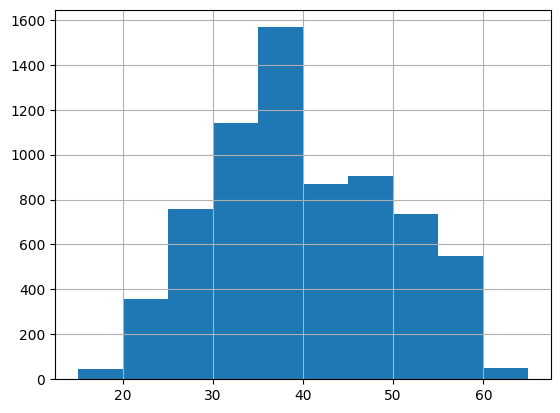

In [377]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10歳で分けて5足す
    tmp = tmp//10 * 10
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

# ヒストグラムを描く
all_df["Age"].hist()

In [378]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損は最頻値で補完する
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

# one-hot化して追加する
all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact"] = 0
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact"] = 1

# 列名を変更
all_df = all_df.rename(columns={"TypeofContact":"CompanyInvited"})

print(all_df["CompanyInvited"].value_counts())

CompanyInvited
0    4462
1    2516
Name: count, dtype: int64


In [379]:
#########################
# "CityTier"の処理 #
#########################
print(all_df["CityTier"].value_counts())

CityTier
2    3160
1    2991
3     827
Name: count, dtype: int64


In [380]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

# 重要でないため、10分刻みのカテゴリにする
all_df["DurationOfPitch"] = (all_df["DurationOfPitch"].values // 10).astype(int)

# 分布を確認する
print(all_df["DurationOfPitch"].value_counts())

DurationOfPitch
1    3824
0    1984
2     709
3     461
Name: count, dtype: int64


In [381]:
####################
# "Occupation"の処理 #
####################
# 特徴量を追加する
all_df["SmallBusiness"] = 0
all_df["Salaried"] = 0
all_df["LargeBusiness"] = 0

# one-hot化して追加する
all_df.loc[all_df["Occupation"]=="Small Business","SmallBusiness"] = 1
all_df.loc[all_df["Occupation"]=="Salaried","Salaried"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","LargeBusiness"] = 1

# 元のカラムを削除する
all_df = all_df.drop("Occupation", axis=1)

print(all_df["SmallBusiness"].value_counts())
print(all_df["Salaried"].value_counts())
print(all_df["LargeBusiness"].value_counts())

SmallBusiness
0    3522
1    3456
Name: count, dtype: int64
Salaried
0    4177
1    2801
Name: count, dtype: int64
LargeBusiness
0    6257
1     721
Name: count, dtype: int64


In [382]:
##################
# "Genger"の処理 #
##################
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])
  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"
  else:
    all_df.loc[i,"Gender"] = "Female"

# one-hot化して追加する
all_df.loc[all_df["Gender"]=="Male","Gender"] = 1
all_df.loc[all_df["Gender"]=="Female","Gender"] = 0

# 列名を変更する
all_df = all_df.rename(columns={"Gender":"Male"})

print(all_df["Male"].value_counts())

Male
0    5946
1    1032
Name: count, dtype: int64


In [383]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
print(all_df["NumberOfPersonVisiting"].value_counts())

NumberOfPersonVisiting
2.0    3163
3.0    2773
1.0     686
4.0     356
Name: count, dtype: int64


In [384]:
##################################
# "NumberOfFollowups"の処理 #
##################################

# 欠損を-1で埋めてから中央値を取る
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# 分布の確認
print(all_df["NumberOfFollowups"].value_counts())

NumberOfFollowups
4.0    2834
3.0    2561
5.0    1122
2.0     213
1.0     178
6.0      70
Name: count, dtype: int64


In [385]:
##########################
# "ProductPitched"の処理 #
##########################
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

# ラベルエンコード
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched"] = 1
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched"] = 2
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched"] = 3
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched"] = 4
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched"] = 5

# 分布の確認
print(all_df["ProductPitched"].value_counts())

ProductPitched
1    2347
3    2091
2    1614
4     640
5     286
Name: count, dtype: int64


In [386]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# 順番に意味があるので2引く
all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

# 分布を確認する
all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
1.0,4328
2.0,2254
3.0,396


In [387]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

# 3グループに分割する
all_df.loc[all_df["NumberOfTrips"]<4,"NumberOfTrips"] = 1
all_df.loc[(all_df["NumberOfTrips"]>=4)& (all_df["NumberOfTrips"]<6),"NumberOfTrips"] = 2
all_df.loc[all_df["NumberOfTrips"]>=6,"NumberOfTrips"] = 3

# 分布を確認する
all_df["NumberOfTrips"].value_counts()

,count
NumberOfTrips,
1,4854
2,1304
3,820


In [388]:
#########################
# "Passport"の処理 #
#########################
print(all_df["Passport"].value_counts())

Passport
0    6288
1     690
Name: count, dtype: int64


In [389]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
print(all_df["PitchSatisfactionScore"].value_counts())

PitchSatisfactionScore
2    2500
4    1452
1    1439
3    1344
5     243
Name: count, dtype: int64


In [390]:
#########################
# "Designation"の処理 #
#########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

# ラベルエンコード
all_df.loc[all_df["Designation"]=="Executive","Designation"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation"] = 1

# 分布の確認
all_df["Designation"].value_counts()

,count
Designation,
5,2330
1,2117
2,1632
3,635
4,264


<Axes: >

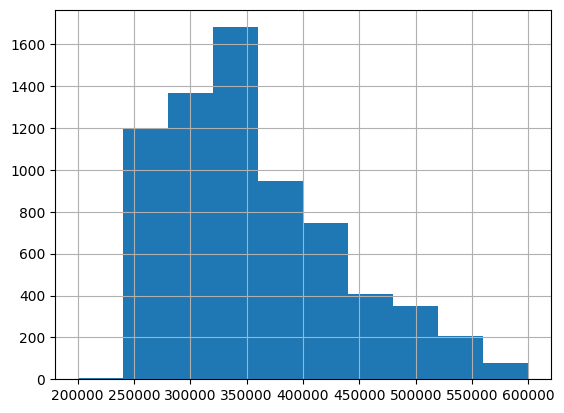

In [391]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

# 分布の確認
all_df["MonthlyIncome"].hist()

In [392]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [393]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [394]:
# 車保有率
print(all_df["CarHolder"].value_counts())

CarHolder
0    4408
1    2570
Name: count, dtype: int64


In [395]:
# 子供の数
print(all_df["NumofChild"].value_counts())

NumofChild
0    5015
1    1347
2     571
3      45
Name: count, dtype: int64


In [396]:
# 婚姻歴

# 特徴量を追加する
all_df["Family"] = 0
all_df["Single"] = 0
all_df["Divorce"] = 0

# one-hot化して追加する
all_df.loc[all_df["Married"]=="Married","Family"] = 1
all_df.loc[all_df["Married"]=="Single","Single"] = 1
all_df.loc[all_df["Married"]=="Divorce","Divorce"] = 1

# 元のカラムを削除する
all_df = all_df.drop("Married", axis=1)

print(all_df["Family"].value_counts())
print(all_df["Single"].value_counts())
print(all_df["Divorce"].value_counts())

Family
0    4132
1    2846
Name: count, dtype: int64
Single
0    4534
1    2444
Name: count, dtype: int64
Divorce
0    5290
1    1688
Name: count, dtype: int64


In [397]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch', 'Male',
       'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched',
       'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'SmallBusiness', 'Salaried', 'LargeBusiness', 'CarHolder', 'NumofChild',
       'Family', 'Single', 'Divorce'],
      dtype='object')

In [398]:
# 順番を整列させる
col = ['id', 'Age', "CompanyInvited", 'CityTier', 'DurationOfPitch',
       'SmallBusiness', 'Salaried', 'LargeBusiness',
       'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', "CarHolder",
       "NumofChild", 'Family', 'Single', 'Divorce',
       'ProdTaken']

all_df = all_df.reindex(columns=col)

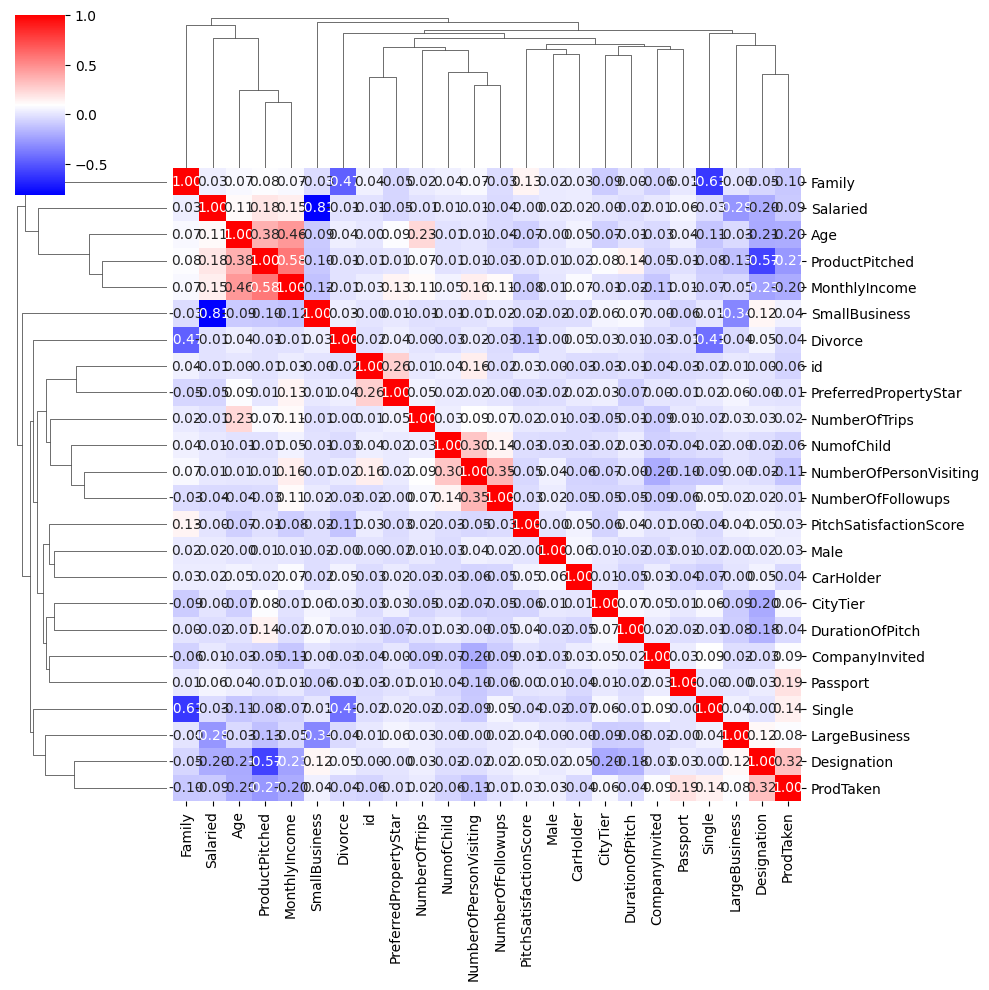

In [399]:
# 相関係数を確認する
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [400]:
# "Salaried" と "SmallBusiness" が0.6 超えるため、サラリーマンかそうでないかに分ける
all_df = all_df.drop("SmallBusiness", axis=1)
all_df = all_df.drop("LargeBusiness", axis=1)

In [401]:
# "Family" と "Single" が0.6 超えるため、独身かそうでないかに分ける
all_df = all_df.drop("Family", axis=1)
all_df = all_df.drop("Divorce", axis=1)

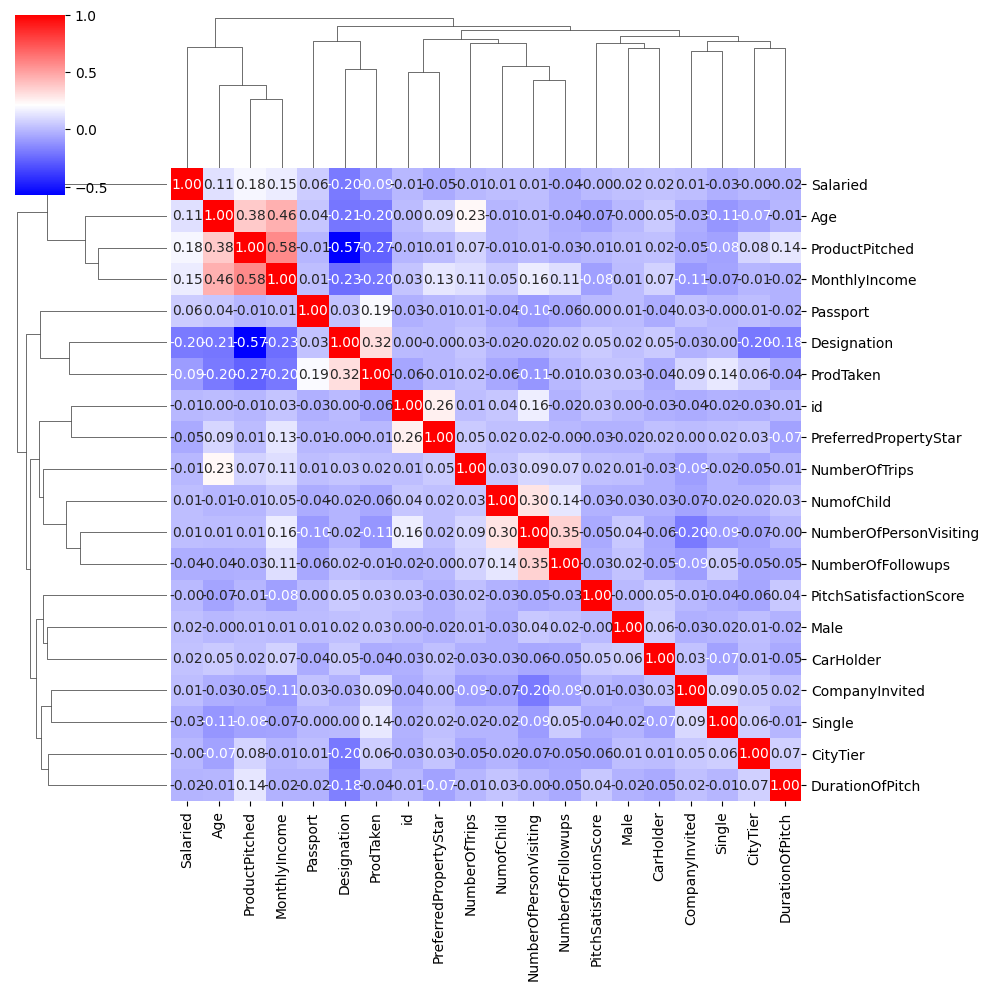

In [402]:
# 相関係数がすべて0.6未満に収まったので次のステップに進む
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

# 特徴量エンジニアリング

In [403]:
#-------------------------------------------------------------------------------------------
# カテゴリ列 x 13
# CompanyInvited, CityTier, DurationOfPitch, Salaried, Male, ProductPitched, PreferredPropertyStar,
# NumberOfTrips, Passport, PitchSatisfactionScore, Designation, CarHolder, Single
# 数値列 x 5
# Age, NumberOfPersonVisiting, NumberOfFollowups, MonthlyIncome, NumofChild
#-------------------------------------------------------------------------------------------
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken'],
      dtype='object')

In [ ]:
# 検討の結果、重要度が低いものを抹消する
# all_df = all_df.drop("Occupation_LE", axis=1)

In [ ]:
# クロス特徴量
# 「役職」x「商品ランク」
# all_df["Designation_ProductPitched"] = all_df["Designation_LE"] * all_df["ProductPitched_LE"]

In [ ]:
# 月収、年齢はLogを取る
# all_df["MonthlyIncomeLOG"] = np.log1p(all_df["MonthlyIncome"])
# all_df["AgeLOG"] = np.log1p(all_df["Age"])

# # 元の列削除
# all_df = all_df.drop("Age", axis=1)
# all_df = all_df.drop("MonthlyIncome", axis=1)

# ここから学習作業

In [404]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [405]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)
print(CATS)

['CompanyInvited', 'Male', 'ProductPitched', 'Designation']


In [406]:
# オブジェクト型はint型に変換する
all_df[CATS] = all_df[CATS].astype(int)

In [407]:
# カラムを制限
all_df2 = all_df[FEATURES]

# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)
FEATURES = test.columns

In [408]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

def objective(trial):

  lgbm_params = {
      'objective': 'binary',
      "device": "cpu",
      'metric': 'auc',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'learning_rate': 0.1,

      'num_leaves': trial.suggest_int('num_leaves', 16, 256),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
      'max_depth': trial.suggest_int('max_depth', 3, 12),

      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  score = roc_auc_score(train[TARGET],oof_lgb)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-25 07:33:23,619] A new study created in memory with name: no-name-855cf00c-8485-4adf-ab67-350292c21230
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.895533	valid's auc: 0.834099
#########################
### Fold 2
#########################
[100]	train's auc: 0.904532	valid's auc: 0.804196
#########################
### Fold 3
#########################
[100]	train's auc: 0.896192	valid's auc: 0.828147


[I 2025-05-25 07:33:24,137] Trial 0 finished with value: 0.818199975252585 and parameters: {'num_leaves': 196, 'min_data_in_leaf': 16, 'feature_fraction': 0.7795848234704896, 'bagging_fraction': 0.66625738420472, 'bagging_freq': 1, 'lambda_l1': 3.966371282455865, 'lambda_l2': 1.991914855830704e-08, 'max_depth': 4}. Best is trial 0 with value: 0.818199975252585.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.943623	valid's auc: 0.823549
#########################
### Fold 2
#########################
[100]	train's auc: 0.950482	valid's auc: 0.792419
#########################
### Fold 3
#########################
[100]	train's auc: 0.943899	valid's auc: 0.822603


[I 2025-05-25 07:33:24,689] Trial 1 finished with value: 0.8244049860661294 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 94, 'feature_fraction': 0.7653345343108622, 'bagging_fraction': 0.8368490636124987, 'bagging_freq': 3, 'lambda_l1': 0.19647667032202812, 'lambda_l2': 0.007359473552938016, 'max_depth': 11}. Best is trial 1 with value: 0.8244049860661294.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.921347	valid's auc: 0.825893
#########################
### Fold 2
#########################


[I 2025-05-25 07:33:26,902] Trial 2 finished with value: 0.8215220467188156 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 51, 'feature_fraction': 0.6453580920344659, 'bagging_fraction': 0.9325998826617303, 'bagging_freq': 1, 'lambda_l1': 3.0796692877360448, 'lambda_l2': 1.2427096019924975e-05, 'max_depth': 11}. Best is trial 1 with value: 0.8244049860661294.


[100]	train's auc: 0.928625	valid's auc: 0.799374
#########################
### Fold 3
#########################
[100]	train's auc: 0.917169	valid's auc: 0.827825
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.946828	valid's auc: 0.815839
#########################
### Fold 2
#########################
[100]	train's auc: 0.954778	valid's auc: 0.791392
#########################
### Fold 3
#########################


[I 2025-05-25 07:33:27,461] Trial 3 finished with value: 0.8158667916590451 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 90, 'feature_fraction': 0.5900792734578252, 'bagging_fraction': 0.9626876737038979, 'bagging_freq': 5, 'lambda_l1': 0.2085103968678699, 'lambda_l2': 0.5728476660478011, 'max_depth': 12}. Best is trial 1 with value: 0.8244049860661294.


[100]	train's auc: 0.946748	valid's auc: 0.82236
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.984772	valid's auc: 0.806582
#########################
### Fold 2
#########################
[100]	train's auc: 0.985156	valid's auc: 0.782849
#########################
### Fold 3
#########################
[100]	train's auc: 0.982497	valid's auc: 0.810439


[I 2025-05-25 07:33:28,077] Trial 4 finished with value: 0.8182726035356523 and parameters: {'num_leaves': 248, 'min_data_in_leaf': 49, 'feature_fraction': 0.6660364970537132, 'bagging_fraction': 0.8651346465423425, 'bagging_freq': 4, 'lambda_l1': 1.073871551876313e-06, 'lambda_l2': 0.0005766835619124332, 'max_depth': 9}. Best is trial 1 with value: 0.8244049860661294.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.991143	valid's auc: 0.803187
#########################
### Fold 2
#########################
[100]	train's auc: 0.99062	valid's auc: 0.782921
#########################
### Fold 3
#########################


[I 2025-05-25 07:33:28,691] Trial 5 finished with value: 0.8166583054476592 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 46, 'feature_fraction': 0.8002256654789078, 'bagging_fraction': 0.916106096649647, 'bagging_freq': 1, 'lambda_l1': 2.0596723076999596e-05, 'lambda_l2': 3.721939612382406e-05, 'max_depth': 9}. Best is trial 1 with value: 0.8244049860661294.


[100]	train's auc: 0.989098	valid's auc: 0.799563
#########################
### Fold 1
#########################
[100]	train's auc: 0.968388	valid's auc: 0.81799


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.972841	valid's auc: 0.785169


[I 2025-05-25 07:33:29,279] Trial 6 finished with value: 0.8164330232733299 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 50, 'feature_fraction': 0.5602953370709887, 'bagging_fraction': 0.7337684202997056, 'bagging_freq': 3, 'lambda_l1': 0.0632224231723073, 'lambda_l2': 0.0009642684598359927, 'max_depth': 9}. Best is trial 1 with value: 0.8244049860661294.


#########################
### Fold 3
#########################
[100]	train's auc: 0.970642	valid's auc: 0.81854
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.901246	valid's auc: 0.82547
#########################
### Fold 2
#########################
[100]	train's auc: 0.912259	valid's auc: 0.794842
#########################
### Fold 3
#########################


[I 2025-05-25 07:33:29,722] Trial 7 finished with value: 0.8190930341406729 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 27, 'feature_fraction': 0.5787825053630472, 'bagging_fraction': 0.9152379458927623, 'bagging_freq': 1, 'lambda_l1': 0.011698914897972852, 'lambda_l2': 3.121533809786135e-08, 'max_depth': 3}. Best is trial 1 with value: 0.8244049860661294.


[100]	train's auc: 0.906587	valid's auc: 0.827971
#########################
### Fold 1
#########################
[100]	train's auc: 0.897846	valid's auc: 0.826286
#########################
### Fold 2
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
[I 2025-05-25 07:33:30,165] Trial 8 finished with value: 0.8209450553588914 and parameters: {'num_leaves': 208, 'min_data_in_leaf': 50, 'feature_fraction': 0.9787530870741669, 'bagging_fraction': 0.933621137485503, 'bagging_freq': 3, 'lambda_l1': 4.419703451447803e-05, 'lambda_l2': 0.007092932267340204, 'max_depth': 3}. Best is trial 1 with value: 0.8244049860661294.


[100]	train's auc: 0.910812	valid's auc: 0.796425
#########################
### Fold 3
#########################
[100]	train's auc: 0.900457	valid's auc: 0.827807


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.988129	valid's auc: 0.810993
#########################
### Fold 2
#########################
[100]	train's auc: 0.98908	valid's auc: 0.774293
#########################
### Fold 3
#########################
[100]	train's auc: 0.98895	valid's auc: 0.804761


[I 2025-05-25 07:33:30,747] Trial 9 finished with value: 0.8141082457310709 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 37, 'feature_fraction': 0.7847346326693379, 'bagging_fraction': 0.7838824060464735, 'bagging_freq': 4, 'lambda_l1': 3.356732208898252e-07, 'lambda_l2': 0.0015743274421313115, 'max_depth': 8}. Best is trial 1 with value: 0.8244049860661294.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.886262	valid's auc: 0.825591
#########################
### Fold 2
#########################


[I 2025-05-25 07:33:31,218] Trial 10 finished with value: 0.8195177078513864 and parameters: {'num_leaves': 21, 'min_data_in_leaf': 82, 'feature_fraction': 0.8886191149110614, 'bagging_fraction': 0.5183279554939508, 'bagging_freq': 7, 'lambda_l1': 0.0016002404765587037, 'lambda_l2': 7.578206693308621, 'max_depth': 6}. Best is trial 1 with value: 0.8244049860661294.


[100]	train's auc: 0.890736	valid's auc: 0.798087
#########################
### Fold 3
#########################
[100]	train's auc: 0.887195	valid's auc: 0.829474


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.916471	valid's auc: 0.826637
#########################
### Fold 2
#########################
[100]	train's auc: 0.929164	valid's auc: 0.800492
#########################
### Fold 3
#########################


[I 2025-05-25 07:33:31,838] Trial 11 finished with value: 0.8247687999655687 and parameters: {'num_leaves': 18, 'min_data_in_leaf': 72, 'feature_fraction': 0.6882814797638985, 'bagging_fraction': 0.8091912096971503, 'bagging_freq': 2, 'lambda_l1': 2.107273129875981, 'lambda_l2': 4.586083714323895e-06, 'max_depth': 12}. Best is trial 11 with value: 0.8247687999655687.


[100]	train's auc: 0.916436	valid's auc: 0.828147
#########################
### Fold 1
#########################
[100]	train's auc: 0.864776	valid's auc: 0.835035


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.878984	valid's auc: 0.80051
[200]	train's auc: 0.885413	valid's auc: 0.803362
[300]	train's auc: 0.885928	valid's auc: 0.803718
#########################
### Fold 3
#########################
[100]	train's auc: 0.866866	valid's auc: 0.835374
[200]	train's auc: 0.872598	valid's auc: 0.836552


[I 2025-05-25 07:33:32,583] Trial 12 finished with value: 0.8226958677196872 and parameters: {'num_leaves': 18, 'min_data_in_leaf': 74, 'feature_fraction': 0.6961266245383193, 'bagging_fraction': 0.807700680949381, 'bagging_freq': 3, 'lambda_l1': 7.168764200271461, 'lambda_l2': 1.874509501599304e-06, 'max_depth': 12}. Best is trial 11 with value: 0.8247687999655687.


[300]	train's auc: 0.877379	valid's auc: 0.835805
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.949546	valid's auc: 0.826618
#########################
### Fold 2
#########################
[100]	train's auc: 0.956627	valid's auc: 0.796788


[I 2025-05-25 07:33:33,183] Trial 13 finished with value: 0.8188274029201951 and parameters: {'num_leaves': 46, 'min_data_in_leaf': 70, 'feature_fraction': 0.8744292574445316, 'bagging_fraction': 0.6866474353633656, 'bagging_freq': 2, 'lambda_l1': 0.18809639457654795, 'lambda_l2': 0.04015453242740817, 'max_depth': 11}. Best is trial 11 with value: 0.8247687999655687.


#########################
### Fold 3
#########################
[100]	train's auc: 0.950393	valid's auc: 0.813281
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.939095	valid's auc: 0.824032
#########################
### Fold 2
#########################
[100]	train's auc: 0.948743	valid's auc: 0.794667
#########################
### Fold 3
#########################


[I 2025-05-25 07:33:33,700] Trial 14 finished with value: 0.8234308928436931 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 98, 'feature_fraction': 0.7142794751744465, 'bagging_fraction': 0.8382509034054424, 'bagging_freq': 6, 'lambda_l1': 0.0021372104013996146, 'lambda_l2': 7.063965153924184e-07, 'max_depth': 10}. Best is trial 11 with value: 0.8247687999655687.


[100]	train's auc: 0.940244	valid's auc: 0.825961
#########################
### Fold 1
#########################
[100]	train's auc: 0.914109	valid's auc: 0.827845


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.921971	valid's auc: 0.79387
#########################
### Fold 3
#########################


[I 2025-05-25 07:33:35,120] Trial 15 finished with value: 0.8220200211966989 and parameters: {'num_leaves': 40, 'min_data_in_leaf': 66, 'feature_fraction': 0.5162617801083966, 'bagging_fraction': 0.5838141498627644, 'bagging_freq': 2, 'lambda_l1': 0.4231223402159155, 'lambda_l2': 3.768843232163773e-05, 'max_depth': 6}. Best is trial 11 with value: 0.8247687999655687.


[100]	train's auc: 0.912542	valid's auc: 0.820672
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.934746	valid's auc: 0.821948
#########################
### Fold 2
#########################
[100]	train's auc: 0.938149	valid's auc: 0.785598


[I 2025-05-25 07:33:35,700] Trial 16 finished with value: 0.8230499305996407 and parameters: {'num_leaves': 91, 'min_data_in_leaf': 97, 'feature_fraction': 0.8876048052684069, 'bagging_fraction': 0.7513147210841465, 'bagging_freq': 4, 'lambda_l1': 1.7926434752653126e-08, 'lambda_l2': 0.05623013490638065, 'max_depth': 11}. Best is trial 11 with value: 0.8247687999655687.


#########################
### Fold 3
#########################
[100]	train's auc: 0.930377	valid's auc: 0.820738


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.970049	valid's auc: 0.820679
#########################
### Fold 2
#########################
[100]	train's auc: 0.976647	valid's auc: 0.78619
#########################
### Fold 3
#########################


[I 2025-05-25 07:33:36,353] Trial 17 finished with value: 0.8226914965730212 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 83, 'feature_fraction': 0.8380495254429101, 'bagging_fraction': 0.9968054869880729, 'bagging_freq': 2, 'lambda_l1': 0.020759368710871636, 'lambda_l2': 4.6581814463025346e-07, 'max_depth': 12}. Best is trial 11 with value: 0.8247687999655687.


[100]	train's auc: 0.97052	valid's auc: 0.802654
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.95037	valid's auc: 0.818135
#########################
### Fold 2
#########################
[100]	train's auc: 0.957687	valid's auc: 0.790456
#########################
### Fold 3
#########################


[I 2025-05-25 07:33:38,547] Trial 18 finished with value: 0.8200758696564414 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 61, 'feature_fraction': 0.7372409609422987, 'bagging_fraction': 0.8603702705769897, 'bagging_freq': 5, 'lambda_l1': 0.7473926166672354, 'lambda_l2': 7.780126702215849e-05, 'max_depth': 7}. Best is trial 11 with value: 0.8247687999655687.


[100]	train's auc: 0.952854	valid's auc: 0.819676
#########################
### Fold 1
#########################
[100]	train's auc: 0.929575	valid's auc: 0.820395


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.935473	valid's auc: 0.792438
#########################
### Fold 3
#########################


[I 2025-05-25 07:33:39,120] Trial 19 finished with value: 0.8230432057586159 and parameters: {'num_leaves': 34, 'min_data_in_leaf': 84, 'feature_fraction': 0.638386215022234, 'bagging_fraction': 0.6579501397322629, 'bagging_freq': 3, 'lambda_l1': 0.00025830234203138517, 'lambda_l2': 0.012111182478904152, 'max_depth': 10}. Best is trial 11 with value: 0.8247687999655687.


[100]	train's auc: 0.927389	valid's auc: 0.825238
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.953347	valid's auc: 0.82602
#########################
### Fold 2
#########################
[100]	train's auc: 0.960481	valid's auc: 0.789072


[I 2025-05-25 07:33:39,688] Trial 20 finished with value: 0.8252687918957595 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 76, 'feature_fraction': 0.9617644764119342, 'bagging_fraction': 0.7316555260863044, 'bagging_freq': 2, 'lambda_l1': 0.009054739428998494, 'lambda_l2': 4.386785060329309e-06, 'max_depth': 10}. Best is trial 20 with value: 0.8252687918957595.


#########################
### Fold 3
#########################
[100]	train's auc: 0.954801	valid's auc: 0.813621


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.953333	valid's auc: 0.818975
#########################
### Fold 2
#########################
[100]	train's auc: 0.960481	valid's auc: 0.796033
#########################
### Fold 3
#########################
[100]	train's auc: 0.955005	valid's auc: 0.81616


[I 2025-05-25 07:33:40,298] Trial 21 finished with value: 0.8224524284745909 and parameters: {'num_leaves': 121, 'min_data_in_leaf': 76, 'feature_fraction': 0.9595666592012869, 'bagging_fraction': 0.7242301521464879, 'bagging_freq': 2, 'lambda_l1': 0.012705095843992428, 'lambda_l2': 6.2924019440793055e-06, 'max_depth': 10}. Best is trial 20 with value: 0.8252687918957595.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.952296	valid's auc: 0.817912
#########################
### Fold 2
#########################
[100]	train's auc: 0.958254	valid's auc: 0.79106
#########################
### Fold 3
#########################
[100]	train's auc: 0.951726	valid's auc: 0.82341


[I 2025-05-25 07:33:40,854] Trial 22 finished with value: 0.8203112390923077 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 88, 'feature_fraction': 0.9309504649919736, 'bagging_fraction': 0.7934054119660578, 'bagging_freq': 2, 'lambda_l1': 0.0017664201359272142, 'lambda_l2': 1.4924740144147046e-07, 'max_depth': 11}. Best is trial 20 with value: 0.8252687918957595.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.922456	valid's auc: 0.818099
#########################
### Fold 2
#########################
[100]	train's auc: 0.927838	valid's auc: 0.794401
#########################
### Fold 3
#########################
[100]	train's auc: 0.922954	valid's auc: 0.829374


[I 2025-05-25 07:33:41,431] Trial 23 finished with value: 0.8240246963061794 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 61, 'feature_fraction': 0.7485937479407321, 'bagging_fraction': 0.6056867854491299, 'bagging_freq': 3, 'lambda_l1': 1.2872171944780186, 'lambda_l2': 0.0002051157126443938, 'max_depth': 12}. Best is trial 20 with value: 0.8252687918957595.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.953792	valid's auc: 0.821416
#########################
### Fold 2
#########################
[100]	train's auc: 0.955918	valid's auc: 0.790178
#########################
### Fold 3
#########################
[100]	train's auc: 0.952892	valid's auc: 0.81135


[I 2025-05-25 07:33:42,029] Trial 24 finished with value: 0.8236006950795683 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 92, 'feature_fraction': 0.997140883634235, 'bagging_fraction': 0.8441362350026613, 'bagging_freq': 2, 'lambda_l1': 0.06343832949471115, 'lambda_l2': 2.516190354847034e-06, 'max_depth': 10}. Best is trial 20 with value: 0.8252687918957595.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.950338	valid's auc: 0.823591
#########################
### Fold 2
#########################
[100]	train's auc: 0.948922	valid's auc: 0.790528
#########################
### Fold 3
#########################
[100]	train's auc: 0.946531	valid's auc: 0.817362


[I 2025-05-25 07:33:42,554] Trial 25 finished with value: 0.8197298765857175 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 78, 'feature_fraction': 0.8389199920420445, 'bagging_fraction': 0.7663051846630783, 'bagging_freq': 4, 'lambda_l1': 0.03846737450024413, 'lambda_l2': 0.42083626859972295, 'max_depth': 8}. Best is trial 20 with value: 0.8252687918957595.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.928527	valid's auc: 0.823918
#########################
### Fold 2
#########################
[100]	train's auc: 0.93527	valid's auc: 0.79935
#########################
### Fold 3
#########################


[I 2025-05-25 07:33:43,158] Trial 26 finished with value: 0.8202967806841047 and parameters: {'num_leaves': 91, 'min_data_in_leaf': 100, 'feature_fraction': 0.9250190978360644, 'bagging_fraction': 0.7108016790854966, 'bagging_freq': 3, 'lambda_l1': 0.0004007727850164106, 'lambda_l2': 2.885435155387478e-07, 'max_depth': 11}. Best is trial 20 with value: 0.8252687918957595.


[100]	train's auc: 0.928939	valid's auc: 0.822336
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.967266	valid's auc: 0.80799
#########################
### Fold 2
#########################
[100]	train's auc: 0.972969	valid's auc: 0.783858


[I 2025-05-25 07:33:43,770] Trial 27 finished with value: 0.8164905206640914 and parameters: {'num_leaves': 46, 'min_data_in_leaf': 67, 'feature_fraction': 0.6914983698562422, 'bagging_fraction': 0.8186080568818246, 'bagging_freq': 5, 'lambda_l1': 0.0052206560589707655, 'lambda_l2': 8.651827775514603e-06, 'max_depth': 12}. Best is trial 20 with value: 0.8252687918957595.


#########################
### Fold 3
#########################
[100]	train's auc: 0.967481	valid's auc: 0.806771


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.84892	valid's auc: 0.842467
[200]	train's auc: 0.85076	valid's auc: 0.842938
#########################
### Fold 2
#########################
[100]	train's auc: 0.868072	valid's auc: 0.802715
[200]	train's auc: 0.8734	valid's auc: 0.808075
[300]	train's auc: 0.876169	valid's auc: 0.808836
[400]	train's auc: 0.878085	valid's auc: 0.809434
#########################
### Fold 3
#########################


[I 2025-05-25 07:33:44,664] Trial 28 finished with value: 0.8263128234648532 and parameters: {'num_leaves': 28, 'min_data_in_leaf': 62, 'feature_fraction': 0.6298867130631268, 'bagging_fraction': 0.6195145021827895, 'bagging_freq': 2, 'lambda_l1': 9.352950880634499, 'lambda_l2': 0.00016295701617894033, 'max_depth': 9}. Best is trial 28 with value: 0.8263128234648532.


[100]	train's auc: 0.850693	valid's auc: 0.834742
[200]	train's auc: 0.854695	valid's auc: 0.835143
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.84758	valid's auc: 0.843796
[200]	train's auc: 0.854222	valid's auc: 0.841561
#########################
### Fold 2
#########################
[100]	train's auc: 0.865323	valid's auc: 0.805289
[200]	train's auc: 0.870036	valid's auc: 0.806824
[300]	train's auc: 0.873731	valid's auc: 0.807694
[400]	train's auc: 0.875417	valid's auc: 0.807495
#########################
### Fold 3
#########################
[100]	train's auc: 0.852532	valid's auc: 0.834663
[200]	train's auc: 0.856712	valid's auc: 0.836515
[300]	train's auc: 0.858837	valid's auc: 0.837445
[400]	train's auc: 0.861036	valid's auc: 0.838586
[500]	train's auc: 0.862351	valid's auc: 0.838192
[600]	train's auc: 0.863616	valid's auc: 0.839497


[I 2025-05-25 07:33:45,916] Trial 29 finished with value: 0.8281930890153757 and parameters: {'num_leaves': 210, 'min_data_in_leaf': 61, 'feature_fraction': 0.6330001867306835, 'bagging_fraction': 0.6411106527532715, 'bagging_freq': 1, 'lambda_l1': 9.705215690899342, 'lambda_l2': 6.245549253367784e-08, 'max_depth': 7}. Best is trial 29 with value: 0.8281930890153757.


[700]	train's auc: 0.864946	valid's auc: 0.840469
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.868561	valid's auc: 0.84063
#########################
### Fold 2
#########################
[100]	train's auc: 0.880464	valid's auc: 0.802836
[200]	train's auc: 0.891599	valid's auc: 0.803591
#########################
### Fold 3
#########################
[100]	train's auc: 0.871094	valid's auc: 0.835325


[I 2025-05-25 07:33:46,671] Trial 30 finished with value: 0.8254621310752214 and parameters: {'num_leaves': 208, 'min_data_in_leaf': 37, 'feature_fraction': 0.612575002789216, 'bagging_fraction': 0.6272829713054656, 'bagging_freq': 1, 'lambda_l1': 5.761908279325631, 'lambda_l2': 1.624563320904258e-08, 'max_depth': 5}. Best is trial 29 with value: 0.8281930890153757.


[200]	train's auc: 0.884556	valid's auc: 0.835507
#########################
### Fold 1
#########################
[100]	train's auc: 0.862231	valid's auc: 0.842443


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.876745	valid's auc: 0.804057
[200]	train's auc: 0.885383	valid's auc: 0.804999
#########################
### Fold 3
#########################
[100]	train's auc: 0.867132	valid's auc: 0.832356
[200]	train's auc: 0.875749	valid's auc: 0.834269
[300]	train's auc: 0.880261	valid's auc: 0.835228
[400]	train's auc: 0.885444	valid's auc: 0.836327


[I 2025-05-25 07:33:47,631] Trial 31 finished with value: 0.8261124232023155 and parameters: {'num_leaves': 205, 'min_data_in_leaf': 18, 'feature_fraction': 0.6270145914682386, 'bagging_fraction': 0.6240923805609356, 'bagging_freq': 1, 'lambda_l1': 7.408459395176618, 'lambda_l2': 1.4835855122103905e-08, 'max_depth': 5}. Best is trial 29 with value: 0.8281930890153757.


[500]	train's auc: 0.888823	valid's auc: 0.834426
#########################
### Fold 1
#########################
[100]	train's auc: 0.855613	valid's auc: 0.841688


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.862938	valid's auc: 0.842123
#########################
### Fold 2
#########################
[100]	train's auc: 0.869494	valid's auc: 0.80274
[200]	train's auc: 0.876137	valid's auc: 0.803803
[300]	train's auc: 0.881451	valid's auc: 0.80428
#########################
### Fold 3
#########################
[100]	train's auc: 0.860736	valid's auc: 0.830746
[200]	train's auc: 0.866562	valid's auc: 0.833667
[300]	train's auc: 0.869456	valid's auc: 0.834651


[I 2025-05-25 07:33:50,379] Trial 32 finished with value: 0.8258797437028589 and parameters: {'num_leaves': 213, 'min_data_in_leaf': 10, 'feature_fraction': 0.6231715235675568, 'bagging_fraction': 0.6199626814094726, 'bagging_freq': 1, 'lambda_l1': 9.028530774175557, 'lambda_l2': 1.0107903353441642e-08, 'max_depth': 5}. Best is trial 29 with value: 0.8281930890153757.


[400]	train's auc: 0.873582	valid's auc: 0.836849
[500]	train's auc: 0.87545	valid's auc: 0.836455
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.858933	valid's auc: 0.843482
#########################
### Fold 2
#########################
[100]	train's auc: 0.877454	valid's auc: 0.8099
[200]	train's auc: 0.885099	valid's auc: 0.809694
#########################
### Fold 3
#########################
[100]	train's auc: 0.864072	valid's auc: 0.835969


[I 2025-05-25 07:33:51,141] Trial 33 finished with value: 0.8296207727649318 and parameters: {'num_leaves': 240, 'min_data_in_leaf': 13, 'feature_fraction': 0.5215967189180091, 'bagging_fraction': 0.5500985707598455, 'bagging_freq': 1, 'lambda_l1': 6.788039629410739, 'lambda_l2': 5.841205244455736e-08, 'max_depth': 4}. Best is trial 33 with value: 0.8296207727649318.


[200]	train's auc: 0.871215	valid's auc: 0.839042
[300]	train's auc: 0.87616	valid's auc: 0.838756
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.904644	valid's auc: 0.831337
#########################
### Fold 2
#########################
[100]	train's auc: 0.916544	valid's auc: 0.801301
#########################
### Fold 3
#########################
[100]	train's auc: 0.901244	valid's auc: 0.835198


[I 2025-05-25 07:33:51,736] Trial 34 finished with value: 0.8168022170455891 and parameters: {'num_leaves': 247, 'min_data_in_leaf': 20, 'feature_fraction': 0.5047463214966716, 'bagging_fraction': 0.5348120521369416, 'bagging_freq': 1, 'lambda_l1': 1.96376013563764, 'lambda_l2': 4.010893000166948e-08, 'max_depth': 4}. Best is trial 33 with value: 0.8296207727649318.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.931722	valid's auc: 0.821325
#########################
### Fold 2
#########################


[I 2025-05-25 07:33:52,187] Trial 35 finished with value: 0.811495308750901 and parameters: {'num_leaves': 232, 'min_data_in_leaf': 23, 'feature_fraction': 0.5412564803642534, 'bagging_fraction': 0.5665805264353401, 'bagging_freq': 1, 'lambda_l1': 0.39647293129765954, 'lambda_l2': 9.986676603626283e-08, 'max_depth': 4}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.937106	valid's auc: 0.783574
#########################
### Fold 3
#########################
[100]	train's auc: 0.929803	valid's auc: 0.821303


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.85414	valid's auc: 0.843845
[200]	train's auc: 0.861273	valid's auc: 0.84402
#########################
### Fold 2
#########################
[100]	train's auc: 0.871276	valid's auc: 0.802564
[200]	train's auc: 0.875798	valid's auc: 0.802927
[300]	train's auc: 0.880959	valid's auc: 0.804564
[400]	train's auc: 0.883091	valid's auc: 0.804129
#########################
### Fold 3
#########################
[100]	train's auc: 0.859891	valid's auc: 0.832192
[200]	train's auc: 0.864736	valid's auc: 0.834262
[300]	train's auc: 0.867278	valid's auc: 0.835483
[400]	train's auc: 0.869654	valid's auc: 0.836625
[500]	train's auc: 0.871497	valid's auc: 0.836685
[600]	train's auc: 0.873142	valid's auc: 0.837766
[700]	train's auc: 0.874681	valid's auc: 0.838744
[800]	train's auc: 0.875977	valid's auc: 0.838647
[900]	train's auc: 0.878497	valid's auc: 0.83991


[I 2025-05-25 07:33:53,712] Trial 36 finished with value: 0.8273423966257437 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 10, 'feature_fraction': 0.5981565668779553, 'bagging_fraction': 0.6530341215952226, 'bagging_freq': 1, 'lambda_l1': 9.532531572415053, 'lambda_l2': 5.990681459879773e-08, 'max_depth': 5}. Best is trial 33 with value: 0.8296207727649318.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.94601	valid's auc: 0.826703
#########################
### Fold 2
#########################
[100]	train's auc: 0.956168	valid's auc: 0.789332
#########################
### Fold 3
#########################


[I 2025-05-25 07:33:54,407] Trial 37 finished with value: 0.8172289082086099 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 12, 'feature_fraction': 0.54624120566457, 'bagging_fraction': 0.5603381421593577, 'bagging_freq': 1, 'lambda_l1': 1.834019825477757, 'lambda_l2': 7.436214523367439e-08, 'max_depth': 7}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.947058	valid's auc: 0.824485
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.955929	valid's auc: 0.807332
#########################
### Fold 2
#########################
[100]	train's auc: 0.957374	valid's auc: 0.788244


[I 2025-05-25 07:33:54,957] Trial 38 finished with value: 0.8070865029750696 and parameters: {'num_leaves': 225, 'min_data_in_leaf': 42, 'feature_fraction': 0.5817822732732776, 'bagging_fraction': 0.6601337714260027, 'bagging_freq': 1, 'lambda_l1': 0.1778159056657868, 'lambda_l2': 1.0252391468698347e-06, 'max_depth': 6}. Best is trial 33 with value: 0.8296207727649318.


#########################
### Fold 3
#########################
[100]	train's auc: 0.955235	valid's auc: 0.823259


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.884435	valid's auc: 0.831519
#########################
### Fold 2
#########################
[100]	train's auc: 0.893383	valid's auc: 0.805561
[200]	train's auc: 0.919357	valid's auc: 0.801175
#########################
### Fold 3
#########################


[I 2025-05-25 07:33:55,523] Trial 39 finished with value: 0.822107780372072 and parameters: {'num_leaves': 256, 'min_data_in_leaf': 56, 'feature_fraction': 0.6600654497630825, 'bagging_fraction': 0.5091094140787489, 'bagging_freq': 1, 'lambda_l1': 0.8630509802093381, 'lambda_l2': 1.4344828762488655e-07, 'max_depth': 3}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.883148	valid's auc: 0.831578
#########################
### Fold 1
#########################
[100]	train's auc: 0.912355	valid's auc: 0.829633


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.91966	valid's auc: 0.802353


[I 2025-05-25 07:33:56,177] Trial 40 finished with value: 0.8203973170574248 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 31, 'feature_fraction': 0.60041033866414, 'bagging_fraction': 0.6785859135666825, 'bagging_freq': 1, 'lambda_l1': 3.045678963042572, 'lambda_l2': 4.567726994259902e-08, 'max_depth': 8}. Best is trial 33 with value: 0.8296207727649318.


#########################
### Fold 3
#########################
[100]	train's auc: 0.91016	valid's auc: 0.831815


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.856882	valid's auc: 0.844679
[200]	train's auc: 0.86289	valid's auc: 0.843029
#########################
### Fold 2
#########################
[100]	train's auc: 0.872189	valid's auc: 0.805392
[200]	train's auc: 0.87822	valid's auc: 0.804667
#########################
### Fold 3
#########################
[100]	train's auc: 0.862548	valid's auc: 0.833558
[200]	train's auc: 0.869662	valid's auc: 0.835513


[I 2025-05-25 07:33:57,144] Trial 41 finished with value: 0.8282515951322911 and parameters: {'num_leaves': 231, 'min_data_in_leaf': 16, 'feature_fraction': 0.5589272594170506, 'bagging_fraction': 0.6392158876709038, 'bagging_freq': 1, 'lambda_l1': 8.359166521420558, 'lambda_l2': 1.0777150438632916e-08, 'max_depth': 5}. Best is trial 33 with value: 0.8296207727649318.


[300]	train's auc: 0.872444	valid's auc: 0.836479
[400]	train's auc: 0.876033	valid's auc: 0.83722
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.889237	valid's auc: 0.838322
#########################
### Fold 2
#########################
[100]	train's auc: 0.901241	valid's auc: 0.804528
#########################
### Fold 3
#########################


[I 2025-05-25 07:33:57,876] Trial 42 finished with value: 0.8265293633458506 and parameters: {'num_leaves': 234, 'min_data_in_leaf': 14, 'feature_fraction': 0.5622320757065759, 'bagging_fraction': 0.5939274894004758, 'bagging_freq': 1, 'lambda_l1': 3.499221516670521, 'lambda_l2': 2.2756928026898995e-07, 'max_depth': 4}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.890134	valid's auc: 0.834135
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.901358	valid's auc: 0.834866
#########################
### Fold 2
#########################
[100]	train's auc: 0.909147	valid's auc: 0.802504
#########################
### Fold 3
#########################


[I 2025-05-25 07:33:58,543] Trial 43 finished with value: 0.826319548305878 and parameters: {'num_leaves': 232, 'min_data_in_leaf': 13, 'feature_fraction': 0.533659664416322, 'bagging_fraction': 0.5863784282937708, 'bagging_freq': 1, 'lambda_l1': 2.828367427163284, 'lambda_l2': 2.5329882121613013e-07, 'max_depth': 4}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.900506	valid's auc: 0.832659
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.944206	valid's auc: 0.81538
#########################
### Fold 2
#########################
[100]	train's auc: 0.951675	valid's auc: 0.792758


[I 2025-05-25 07:33:59,076] Trial 44 finished with value: 0.8049641431476561 and parameters: {'num_leaves': 221, 'min_data_in_leaf': 26, 'feature_fraction': 0.5666546293748915, 'bagging_fraction': 0.5407200983025431, 'bagging_freq': 1, 'lambda_l1': 0.541141734391236, 'lambda_l2': 3.781285083880102e-08, 'max_depth': 5}. Best is trial 33 with value: 0.8296207727649318.


#########################
### Fold 3
#########################
[100]	train's auc: 0.945211	valid's auc: 0.820107
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.899581	valid's auc: 0.831035
#########################
### Fold 2
#########################
[100]	train's auc: 0.912962	valid's auc: 0.790685
#########################
### Fold 3
#########################


[I 2025-05-25 07:33:59,571] Trial 45 finished with value: 0.8109183173909768 and parameters: {'num_leaves': 242, 'min_data_in_leaf': 16, 'feature_fraction': 0.5242768414758174, 'bagging_fraction': 0.6465078601257406, 'bagging_freq': 1, 'lambda_l1': 0.12328716272117778, 'lambda_l2': 7.80544732060014e-08, 'max_depth': 3}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.905447	valid's auc: 0.830473
#########################
### Fold 1
#########################
[100]	train's auc: 0.881314	valid's auc: 0.839506


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.894482	valid's auc: 0.805054
[200]	train's auc: 0.911514	valid's auc: 0.802788
#########################
### Fold 3
#########################
[100]	train's auc: 0.880299	valid's auc: 0.83224


[I 2025-05-25 07:34:02,010] Trial 46 finished with value: 0.8264197484371469 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 31, 'feature_fraction': 0.5604267353827291, 'bagging_fraction': 0.6987881891312874, 'bagging_freq': 2, 'lambda_l1': 4.082487921352356, 'lambda_l2': 1.172322779369402e-06, 'max_depth': 4}. Best is trial 33 with value: 0.8296207727649318.


[200]	train's auc: 0.899583	valid's auc: 0.834645
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.951076	valid's auc: 0.810878
#########################
### Fold 2
#########################
[100]	train's auc: 0.956862	valid's auc: 0.795199
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:02,544] Trial 47 finished with value: 0.8165117039133195 and parameters: {'num_leaves': 238, 'min_data_in_leaf': 21, 'feature_fraction': 0.597546680745419, 'bagging_fraction': 0.5870730129037379, 'bagging_freq': 7, 'lambda_l1': 1.1231712097742212, 'lambda_l2': 1.026907672375231e-08, 'max_depth': 6}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.950318	valid's auc: 0.820514
#########################
### Fold 1
#########################
[100]	train's auc: 0.928277	valid's auc: 0.818371
#########################
### Fold 2
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
[I 2025-05-25 07:34:03,020] Trial 48 finished with value: 0.8041191668728951 and parameters: {'num_leaves': 256, 'min_data_in_leaf': 16, 'feature_fraction': 0.5041174695142246, 'bagging_fraction': 0.5508725740600673, 'bagging_freq': 2, 'lambda_l1': 0.3590756921802153, 'lambda_l2': 4.2057305739498437e-07, 'max_depth': 4}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.93766	valid's auc: 0.785096
#########################
### Fold 3
#########################
[100]	train's auc: 0.929119	valid's auc: 0.817083


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.978089	valid's auc: 0.805162
#########################
### Fold 2
#########################


[I 2025-05-25 07:34:03,535] Trial 49 finished with value: 0.8101974144331228 and parameters: {'num_leaves': 223, 'min_data_in_leaf': 10, 'feature_fraction': 0.6634009927766675, 'bagging_fraction': 0.6457201075531116, 'bagging_freq': 1, 'lambda_l1': 1.0383590224663073e-05, 'lambda_l2': 2.0772489388167598e-05, 'max_depth': 5}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.980501	valid's auc: 0.779054
#########################
### Fold 3
#########################
[100]	train's auc: 0.981425	valid's auc: 0.80821


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.847279	valid's auc: 0.838908
#########################
### Fold 2
#########################
[100]	train's auc: 0.865711	valid's auc: 0.801501
[200]	train's auc: 0.870435	valid's auc: 0.804063
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:04,248] Trial 50 finished with value: 0.8207520524214809 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 29, 'feature_fraction': 0.579318260778053, 'bagging_fraction': 0.592749577977412, 'bagging_freq': 6, 'lambda_l1': 9.561822251202894, 'lambda_l2': 2.6749064954699806e-08, 'max_depth': 7}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.85466	valid's auc: 0.826684
[200]	train's auc: 0.858462	valid's auc: 0.830661
[300]	train's auc: 0.859202	valid's auc: 0.830916


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.885151	valid's auc: 0.83512
#########################
### Fold 2
#########################
[100]	train's auc: 0.896845	valid's auc: 0.801549
[200]	train's auc: 0.915702	valid's auc: 0.802425
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:05,024] Trial 51 finished with value: 0.8243020959984506 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 24, 'feature_fraction': 0.5577702126009545, 'bagging_fraction': 0.6811964986072996, 'bagging_freq': 2, 'lambda_l1': 3.9146418614768743, 'lambda_l2': 1.2532362024882278e-06, 'max_depth': 4}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.882328	valid's auc: 0.834918
[200]	train's auc: 0.903124	valid's auc: 0.835878


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.875441	valid's auc: 0.838969
#########################
### Fold 2
#########################
[100]	train's auc: 0.890053	valid's auc: 0.803688
[200]	train's auc: 0.90849	valid's auc: 0.801561
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:05,725] Trial 52 finished with value: 0.8263867967161258 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 15, 'feature_fraction': 0.5609988405395481, 'bagging_fraction': 0.7023918424126123, 'bagging_freq': 1, 'lambda_l1': 3.5831077237024647, 'lambda_l2': 1.6849331616193963e-07, 'max_depth': 3}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.877337	valid's auc: 0.834827
[200]	train's auc: 0.893183	valid's auc: 0.834092


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.907114	valid's auc: 0.829452
#########################
### Fold 2
#########################


[I 2025-05-25 07:34:06,226] Trial 53 finished with value: 0.8153725158437255 and parameters: {'num_leaves': 215, 'min_data_in_leaf': 33, 'feature_fraction': 0.6018815925697208, 'bagging_fraction': 0.6404074937118572, 'bagging_freq': 2, 'lambda_l1': 1.1751566211671483, 'lambda_l2': 6.392304857628271e-07, 'max_depth': 4}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.923255	valid's auc: 0.793453
#########################
### Fold 3
#########################
[100]	train's auc: 0.910583	valid's auc: 0.825827


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.877475	valid's auc: 0.841537
#########################
### Fold 2
#########################
[100]	train's auc: 0.892358	valid's auc: 0.805585
[200]	train's auc: 0.904647	valid's auc: 0.803827
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:06,938] Trial 54 finished with value: 0.8292764609044642 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 54, 'feature_fraction': 0.5253473937030864, 'bagging_fraction': 0.6954193207162586, 'bagging_freq': 1, 'lambda_l1': 4.199115650533711, 'lambda_l2': 7.545046817417011e-08, 'max_depth': 5}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.879933	valid's auc: 0.84059
[200]	train's auc: 0.893028	valid's auc: 0.839758
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.925793	valid's auc: 0.819362
#########################
### Fold 2
#########################
[100]	train's auc: 0.938063	valid's auc: 0.797441


[I 2025-05-25 07:34:07,509] Trial 55 finished with value: 0.8205274427312537 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 54, 'feature_fraction': 0.5316897864147321, 'bagging_fraction': 0.5691950489302064, 'bagging_freq': 1, 'lambda_l1': 0.08391730757169207, 'lambda_l2': 2.688389366374356e-08, 'max_depth': 5}. Best is trial 33 with value: 0.8296207727649318.


#########################
### Fold 3
#########################
[100]	train's auc: 0.927993	valid's auc: 0.818528


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.94525	valid's auc: 0.820794
#########################
### Fold 2
#########################
[100]	train's auc: 0.951696	valid's auc: 0.792504
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:08,125] Trial 56 finished with value: 0.8089210396066236 and parameters: {'num_leaves': 232, 'min_data_in_leaf': 47, 'feature_fraction': 0.5154311648774649, 'bagging_fraction': 0.6667660908866769, 'bagging_freq': 1, 'lambda_l1': 0.26590223866112883, 'lambda_l2': 5.7849628816048375e-08, 'max_depth': 6}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.945402	valid's auc: 0.819864
#########################
### Fold 1
#########################
[100]	train's auc: 0.935014	valid's auc: 0.824715
#########################
### Fold 2
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.941035	valid's auc: 0.795114
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:08,652] Trial 57 finished with value: 0.8086473385769162 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 43, 'feature_fraction': 0.5791829457531106, 'bagging_fraction': 0.5237428949117293, 'bagging_freq': 1, 'lambda_l1': 2.674471434210353e-07, 'lambda_l2': 2.898689339718245e-07, 'max_depth': 5}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.931076	valid's auc: 0.821012
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.95589	valid's auc: 0.816975
#########################
### Fold 2
#########################
[100]	train's auc: 0.963498	valid's auc: 0.787465


[I 2025-05-25 07:34:09,282] Trial 58 finished with value: 0.8165322146784448 and parameters: {'num_leaves': 204, 'min_data_in_leaf': 21, 'feature_fraction': 0.520507336271023, 'bagging_fraction': 0.6051888187011496, 'bagging_freq': 2, 'lambda_l1': 0.6991334560573266, 'lambda_l2': 2.0441292170373763e-08, 'max_depth': 6}. Best is trial 33 with value: 0.8296207727649318.


#########################
### Fold 3
#########################
[100]	train's auc: 0.95602	valid's auc: 0.812874


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.887386	valid's auc: 0.830183
#########################
### Fold 2
#########################
[100]	train's auc: 0.903369	valid's auc: 0.803229
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:09,860] Trial 59 finished with value: 0.8210738360645154 and parameters: {'num_leaves': 216, 'min_data_in_leaf': 17, 'feature_fraction': 0.6451661431013995, 'bagging_fraction': 0.7499097600174919, 'bagging_freq': 1, 'lambda_l1': 2.1794110103224247, 'lambda_l2': 2.3280345588535273e-06, 'max_depth': 3}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.891494	valid's auc: 0.83269
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.874446	valid's auc: 0.839754
#########################
### Fold 2
#########################
[100]	train's auc: 0.881298	valid's auc: 0.807156
[200]	train's auc: 0.899613	valid's auc: 0.808395
[300]	train's auc: 0.907962	valid's auc: 0.80515
#########################
### Fold 3
#########################
[100]	train's auc: 0.867622	valid's auc: 0.831256
[200]	train's auc: 0.884949	valid's auc: 0.833175


[I 2025-05-25 07:34:11,029] Trial 60 finished with value: 0.8263874692002282 and parameters: {'num_leaves': 249, 'min_data_in_leaf': 55, 'feature_fraction': 0.5471921284029293, 'bagging_fraction': 0.5004993741723224, 'bagging_freq': 2, 'lambda_l1': 4.0563870841452765, 'lambda_l2': 6.852439085646196e-08, 'max_depth': 6}. Best is trial 33 with value: 0.8296207727649318.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.881345	valid's auc: 0.837386
#########################
### Fold 2
#########################
[100]	train's auc: 0.894534	valid's auc: 0.805755
[200]	train's auc: 0.90909	valid's auc: 0.804304
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:14,470] Trial 61 finished with value: 0.8242045858035916 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 13, 'feature_fraction': 0.5687530499320569, 'bagging_fraction': 0.6979689134143444, 'bagging_freq': 1, 'lambda_l1': 4.600238658124357, 'lambda_l2': 1.417548661830674e-07, 'max_depth': 4}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.883946	valid's auc: 0.832422
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.927081	valid's auc: 0.825954
#########################
### Fold 2
#########################
[100]	train's auc: 0.935653	valid's auc: 0.794528
#########################
### Fold 3
#########################
[100]	train's auc: 0.926212	valid's auc: 0.824206


[I 2025-05-25 07:34:15,113] Trial 62 finished with value: 0.8234029847534404 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 35, 'feature_fraction': 0.5513769565409506, 'bagging_fraction': 0.7210502975207673, 'bagging_freq': 2, 'lambda_l1': 1.3907059827936752, 'lambda_l2': 4.178134676835217e-07, 'max_depth': 5}. Best is trial 33 with value: 0.8296207727649318.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.851027	valid's auc: 0.841636
[200]	train's auc: 0.857815	valid's auc: 0.841567
#########################
### Fold 2
#########################
[100]	train's auc: 0.868463	valid's auc: 0.799549
[200]	train's auc: 0.875751	valid's auc: 0.808274
[300]	train's auc: 0.875941	valid's auc: 0.808419
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:15,757] Trial 63 finished with value: 0.8252361764167896 and parameters: {'num_leaves': 227, 'min_data_in_leaf': 26, 'feature_fraction': 0.6132539993192818, 'bagging_fraction': 0.6671280839563711, 'bagging_freq': 3, 'lambda_l1': 9.367518534831163, 'lambda_l2': 1.1816783667216629e-06, 'max_depth': 4}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.855978	valid's auc: 0.83477
[200]	train's auc: 0.85779	valid's auc: 0.835277
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.877711	valid's auc: 0.839917
#########################
### Fold 2
#########################
[100]	train's auc: 0.889256	valid's auc: 0.809277
[200]	train's auc: 0.90791	valid's auc: 0.804232
#########################
### Fold 3
#########################
[100]	train's auc: 0.878662	valid's auc: 0.836588


[I 2025-05-25 07:34:16,449] Trial 64 finished with value: 0.8289153369414346 and parameters: {'num_leaves': 239, 'min_data_in_leaf': 19, 'feature_fraction': 0.5908810771758798, 'bagging_fraction': 0.6016110005989084, 'bagging_freq': 1, 'lambda_l1': 3.255609551461777, 'lambda_l2': 0.0014425131332080215, 'max_depth': 3}. Best is trial 33 with value: 0.8296207727649318.


[200]	train's auc: 0.898542	valid's auc: 0.833764
#########################
### Fold 1
#########################
[100]	train's auc: 0.900307	valid's auc: 0.825688
#########################
### Fold 2
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
[I 2025-05-25 07:34:16,877] Trial 65 finished with value: 0.810546769924359 and parameters: {'num_leaves': 240, 'min_data_in_leaf': 19, 'feature_fraction': 0.5876800874792993, 'bagging_fraction': 0.6005980753510625, 'bagging_freq': 1, 'lambda_l1': 0.6653696700173235, 'lambda_l2': 0.001543688297243395, 'max_depth': 3}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.912685	valid's auc: 0.801543
#########################
### Fold 3
#########################
[100]	train's auc: 0.902362	valid's auc: 0.825263


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.889995	valid's auc: 0.832957
#########################
### Fold 2
#########################
[100]	train's auc: 0.904332	valid's auc: 0.79825
#########################
### Fold 3
#########################
[100]	train's auc: 0.896698	valid's auc: 0.827734


[I 2025-05-25 07:34:17,468] Trial 66 finished with value: 0.8216760455782826 and parameters: {'num_leaves': 244, 'min_data_in_leaf': 14, 'feature_fraction': 0.7209402506305301, 'bagging_fraction': 0.6411753648104639, 'bagging_freq': 1, 'lambda_l1': 1.8940098855167748, 'lambda_l2': 0.0003508960404238596, 'max_depth': 3}. Best is trial 33 with value: 0.8296207727649318.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.879969	valid's auc: 0.842667
#########################
### Fold 2
#########################
[100]	train's auc: 0.891042	valid's auc: 0.809422
[200]	train's auc: 0.90278	valid's auc: 0.806872
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:18,288] Trial 67 finished with value: 0.8295925284326279 and parameters: {'num_leaves': 211, 'min_data_in_leaf': 10, 'feature_fraction': 0.5028606878325541, 'bagging_fraction': 0.6085841037207507, 'bagging_freq': 1, 'lambda_l1': 4.869133652371878, 'lambda_l2': 0.002936729427673529, 'max_depth': 5}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.882316	valid's auc: 0.836388
[200]	train's auc: 0.896602	valid's auc: 0.83476


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.85967	valid's auc: 0.840715
#########################
### Fold 2
#########################
[100]	train's auc: 0.870873	valid's auc: 0.805845
[200]	train's auc: 0.882384	valid's auc: 0.808117
#########################
### Fold 3
#########################
[100]	train's auc: 0.860123	valid's auc: 0.831912
[200]	train's auc: 0.867807	valid's auc: 0.833619


[I 2025-05-25 07:34:19,177] Trial 68 finished with value: 0.8269826176309192 and parameters: {'num_leaves': 211, 'min_data_in_leaf': 63, 'feature_fraction': 0.5028134553379969, 'bagging_fraction': 0.6127956417505869, 'bagging_freq': 6, 'lambda_l1': 6.059086417716811, 'lambda_l2': 0.003803400416971288, 'max_depth': 7}. Best is trial 33 with value: 0.8296207727649318.


[300]	train's auc: 0.872503	valid's auc: 0.832781
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.972101	valid's auc: 0.814431
#########################
### Fold 2
#########################


[I 2025-05-25 07:34:19,733] Trial 69 finished with value: 0.8053165248173534 and parameters: {'num_leaves': 219, 'min_data_in_leaf': 11, 'feature_fraction': 0.7737997929846865, 'bagging_fraction': 0.6346227991547316, 'bagging_freq': 2, 'lambda_l1': 0.041222899843018065, 'lambda_l2': 0.004076909177876901, 'max_depth': 5}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.981169	valid's auc: 0.775284
#########################
### Fold 3
#########################
[100]	train's auc: 0.973728	valid's auc: 0.802915
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.918113	valid's auc: 0.828908
#########################
### Fold 2
#########################
[100]	train's auc: 0.930037	valid's auc: 0.798758


[I 2025-05-25 07:34:20,326] Trial 70 finished with value: 0.8210186923681124 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 70, 'feature_fraction': 0.5317801642026745, 'bagging_fraction': 0.5755884256351768, 'bagging_freq': 1, 'lambda_l1': 0.22350644036477707, 'lambda_l2': 0.0006793523429211175, 'max_depth': 6}. Best is trial 33 with value: 0.8296207727649318.


#########################
### Fold 3
#########################
[100]	train's auc: 0.921081	valid's auc: 0.825894


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.861559	valid's auc: 0.840219
#########################
### Fold 2
#########################
[100]	train's auc: 0.878241	valid's auc: 0.806014
[200]	train's auc: 0.885955	valid's auc: 0.80532
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:21,068] Trial 71 finished with value: 0.8250115667265625 and parameters: {'num_leaves': 210, 'min_data_in_leaf': 64, 'feature_fraction': 0.5020108073953683, 'bagging_fraction': 0.6204321504020337, 'bagging_freq': 5, 'lambda_l1': 5.644196835006336, 'lambda_l2': 0.03324595021458992, 'max_depth': 7}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.861653	valid's auc: 0.834852
[200]	train's auc: 0.871125	valid's auc: 0.83674


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.864743	valid's auc: 0.840552
#########################
### Fold 2
#########################
[100]	train's auc: 0.87574	valid's auc: 0.805863
[200]	train's auc: 0.887978	valid's auc: 0.806957
#########################
### Fold 3
#########################
[100]	train's auc: 0.86429	valid's auc: 0.834864
[200]	train's auc: 0.872808	valid's auc: 0.837384


[I 2025-05-25 07:34:21,793] Trial 72 finished with value: 0.8264923767202143 and parameters: {'num_leaves': 203, 'min_data_in_leaf': 68, 'feature_fraction': 0.5162443437809281, 'bagging_fraction': 0.6574795551405838, 'bagging_freq': 6, 'lambda_l1': 5.382181416659167, 'lambda_l2': 0.004332086516360853, 'max_depth': 8}. Best is trial 33 with value: 0.8296207727649318.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.908219	valid's auc: 0.822824
#########################
### Fold 2
#########################
[100]	train's auc: 0.913009	valid's auc: 0.806897
#########################
### Fold 3
#########################
[100]	train's auc: 0.902054	valid's auc: 0.821455


[I 2025-05-25 07:34:22,379] Trial 73 finished with value: 0.8208125759907037 and parameters: {'num_leaves': 229, 'min_data_in_leaf': 58, 'feature_fraction': 0.5402550355901796, 'bagging_fraction': 0.6145145197103633, 'bagging_freq': 7, 'lambda_l1': 2.0162124701921527, 'lambda_l2': 0.013604905420350328, 'max_depth': 7}. Best is trial 33 with value: 0.8296207727649318.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.845506	valid's auc: 0.844745
[200]	train's auc: 0.849926	valid's auc: 0.843422
#########################
### Fold 2
#########################
[100]	train's auc: 0.863024	valid's auc: 0.801507
[200]	train's auc: 0.869876	valid's auc: 0.805549
[300]	train's auc: 0.873292	valid's auc: 0.808915
[400]	train's auc: 0.875179	valid's auc: 0.809126
[500]	train's auc: 0.877821	valid's auc: 0.809277
#########################
### Fold 3
#########################
[100]	train's auc: 0.848361	valid's auc: 0.8332
[200]	train's auc: 0.851605	valid's auc: 0.834833
[300]	train's auc: 0.856041	valid's auc: 0.839042


[I 2025-05-25 07:34:23,416] Trial 74 finished with value: 0.8281782943651211 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 59, 'feature_fraction': 0.5194685992384058, 'bagging_fraction': 0.5524916951062071, 'bagging_freq': 4, 'lambda_l1': 9.00731127426187, 'lambda_l2': 0.0025995746970659114, 'max_depth': 5}. Best is trial 33 with value: 0.8296207727649318.


[400]	train's auc: 0.855901	valid's auc: 0.840274
#########################
### Fold 1
#########################
[100]	train's auc: 0.843689	valid's auc: 0.843216


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.848526	valid's auc: 0.842171
#########################
### Fold 2
#########################
[100]	train's auc: 0.862876	valid's auc: 0.800425
[200]	train's auc: 0.868052	valid's auc: 0.804649
[300]	train's auc: 0.870951	valid's auc: 0.805585
[400]	train's auc: 0.873178	valid's auc: 0.806214
#########################
### Fold 3
#########################
[100]	train's auc: 0.846885	valid's auc: 0.83136
[200]	train's auc: 0.850615	valid's auc: 0.833309
[300]	train's auc: 0.853873	valid's auc: 0.835331


[I 2025-05-25 07:34:26,105] Trial 75 finished with value: 0.8251561508085948 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 50, 'feature_fraction': 0.522288957070849, 'bagging_fraction': 0.5514605743059662, 'bagging_freq': 4, 'lambda_l1': 9.991207391294955, 'lambda_l2': 0.0016576537458723665, 'max_depth': 5}. Best is trial 33 with value: 0.8296207727649318.


[400]	train's auc: 0.854169	valid's auc: 0.836576
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.904012	valid's auc: 0.828908
#########################
### Fold 2
#########################
[100]	train's auc: 0.916722	valid's auc: 0.804147


[I 2025-05-25 07:34:26,735] Trial 76 finished with value: 0.8189339916504373 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 59, 'feature_fraction': 0.6141966876422101, 'bagging_fraction': 0.5351004433534446, 'bagging_freq': 1, 'lambda_l1': 1.1600764778833261, 'lambda_l2': 7.655072916785243e-05, 'max_depth': 5}. Best is trial 33 with value: 0.8296207727649318.


[200]	train's auc: 0.946342	valid's auc: 0.793422
#########################
### Fold 3
#########################
[100]	train's auc: 0.905948	valid's auc: 0.826981


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.972751	valid's auc: 0.812069
#########################
### Fold 2
#########################
[100]	train's auc: 0.974324	valid's auc: 0.784903
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:27,317] Trial 77 finished with value: 0.8092347534404287 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 10, 'feature_fraction': 0.594025132822115, 'bagging_fraction': 0.5751489486957352, 'bagging_freq': 1, 'lambda_l1': 0.4731479442037917, 'lambda_l2': 0.0017988491407371287, 'max_depth': 5}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.969145	valid's auc: 0.814611
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.926039	valid's auc: 0.830044
#########################
### Fold 2
#########################
[100]	train's auc: 0.929929	valid's auc: 0.799857


[I 2025-05-25 07:34:27,902] Trial 78 finished with value: 0.8218710659680005 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 23, 'feature_fraction': 0.6817000945415869, 'bagging_fraction': 0.5571578475245843, 'bagging_freq': 1, 'lambda_l1': 2.258363872568331, 'lambda_l2': 0.29017202390925284, 'max_depth': 6}. Best is trial 33 with value: 0.8296207727649318.


#########################
### Fold 3
#########################
[100]	train's auc: 0.924498	valid's auc: 0.826587


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.934484	valid's auc: 0.818347
#########################
### Fold 2
#########################
[100]	train's auc: 0.943392	valid's auc: 0.782879
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:28,414] Trial 79 finished with value: 0.8070972627207091 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 18, 'feature_fraction': 0.570370451923282, 'bagging_fraction': 0.5204000801002996, 'bagging_freq': 1, 'lambda_l1': 0.00010606449240787285, 'lambda_l2': 0.0003909003269026541, 'max_depth': 4}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.934981	valid's auc: 0.819275
#########################
### Fold 1
#########################
[100]	train's auc: 0.913672	valid's auc: 0.833337


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.923283	valid's auc: 0.80132


[I 2025-05-25 07:34:29,075] Trial 80 finished with value: 0.8243417725604968 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 53, 'feature_fraction': 0.5437927521183439, 'bagging_fraction': 0.6755584164451822, 'bagging_freq': 1, 'lambda_l1': 0.9436041042014413, 'lambda_l2': 3.0006206301065395, 'max_depth': 6}. Best is trial 33 with value: 0.8296207727649318.


#########################
### Fold 3
#########################
[100]	train's auc: 0.91561	valid's auc: 0.833212


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.859546	valid's auc: 0.840286
#########################
### Fold 2
#########################
[100]	train's auc: 0.87155	valid's auc: 0.805005
[200]	train's auc: 0.882528	valid's auc: 0.807386
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:29,845] Trial 81 finished with value: 0.8260323975941208 and parameters: {'num_leaves': 211, 'min_data_in_leaf': 64, 'feature_fraction': 0.5076214322422808, 'bagging_fraction': 0.6300430091074845, 'bagging_freq': 6, 'lambda_l1': 6.270577147564243, 'lambda_l2': 0.012146032434115807, 'max_depth': 9}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.860413	valid's auc: 0.8332
[200]	train's auc: 0.866165	valid's auc: 0.833388
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.886615	valid's auc: 0.83576
#########################
### Fold 2
#########################
[100]	train's auc: 0.899721	valid's auc: 0.800679
#########################
### Fold 3
#########################
[100]	train's auc: 0.882159	valid's auc: 0.831876


[I 2025-05-25 07:34:30,546] Trial 82 finished with value: 0.825224071702945 and parameters: {'num_leaves': 221, 'min_data_in_leaf': 63, 'feature_fraction': 0.5008520116407601, 'bagging_fraction': 0.6075437401822749, 'bagging_freq': 5, 'lambda_l1': 2.896541924844999, 'lambda_l2': 0.0031526743975346426, 'max_depth': 7}. Best is trial 33 with value: 0.8296207727649318.


[200]	train's auc: 0.904482	valid's auc: 0.833169
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.867201	valid's auc: 0.837609
#########################
### Fold 2
#########################
[100]	train's auc: 0.8821	valid's auc: 0.805477
#########################
### Fold 3
#########################
[100]	train's auc: 0.866619	valid's auc: 0.832969
[200]	train's auc: 0.873696	valid's auc: 0.835343


[I 2025-05-25 07:34:31,316] Trial 83 finished with value: 0.8255724184680273 and parameters: {'num_leaves': 208, 'min_data_in_leaf': 52, 'feature_fraction': 0.5335615745984399, 'bagging_fraction': 0.6549822662203822, 'bagging_freq': 4, 'lambda_l1': 5.665211419750384, 'lambda_l2': 0.00015219999935084575, 'max_depth': 5}. Best is trial 33 with value: 0.8296207727649318.


[300]	train's auc: 0.883047	valid's auc: 0.835951
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.860361	valid's auc: 0.83289
#########################
### Fold 2
#########################
[100]	train's auc: 0.877672	valid's auc: 0.800969
[200]	train's auc: 0.886835	valid's auc: 0.802075
#########################
### Fold 3
#########################
[100]	train's auc: 0.862115	valid's auc: 0.832119


[I 2025-05-25 07:34:32,124] Trial 84 finished with value: 0.8224574721053595 and parameters: {'num_leaves': 249, 'min_data_in_leaf': 66, 'feature_fraction': 0.7998032444191556, 'bagging_fraction': 0.6144017315004221, 'bagging_freq': 6, 'lambda_l1': 6.176561185122672, 'lambda_l2': 0.007781748660777107, 'max_depth': 8}. Best is trial 33 with value: 0.8296207727649318.


[200]	train's auc: 0.872866	valid's auc: 0.834481
[300]	train's auc: 0.878579	valid's auc: 0.833679
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.883452	valid's auc: 0.831815
#########################
### Fold 2
#########################
[100]	train's auc: 0.891872	valid's auc: 0.809344


[I 2025-05-25 07:34:32,703] Trial 85 finished with value: 0.8250357761542516 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 60, 'feature_fraction': 0.5168367666142739, 'bagging_fraction': 0.5840618809520081, 'bagging_freq': 7, 'lambda_l1': 3.0590323459369575, 'lambda_l2': 0.0009770885774880633, 'max_depth': 6}. Best is trial 33 with value: 0.8296207727649318.


#########################
### Fold 3
#########################
[100]	train's auc: 0.878698	valid's auc: 0.833039
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.895152	valid's auc: 0.830655
#########################
### Fold 2
#########################
[100]	train's auc: 0.908249	valid's auc: 0.80022


[I 2025-05-25 07:34:33,304] Trial 86 finished with value: 0.8218071799782652 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 57, 'feature_fraction': 0.5526800426528916, 'bagging_fraction': 0.6281372085367218, 'bagging_freq': 3, 'lambda_l1': 1.412843407034308, 'lambda_l2': 0.024984964200935388, 'max_depth': 4}. Best is trial 33 with value: 0.8296207727649318.


[200]	train's auc: 0.935229	valid's auc: 0.795205
#########################
### Fold 3
#########################
[100]	train's auc: 0.896408	valid's auc: 0.832775


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.84268	valid's auc: 0.848092
[200]	train's auc: 0.848571	valid's auc: 0.846805
#########################
### Fold 2
#########################
[100]	train's auc: 0.8612	valid's auc: 0.797906
[200]	train's auc: 0.867012	valid's auc: 0.801815
[300]	train's auc: 0.871888	valid's auc: 0.805241
[400]	train's auc: 0.872656	valid's auc: 0.806087
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:34,214] Trial 87 finished with value: 0.826903264506827 and parameters: {'num_leaves': 236, 'min_data_in_leaf': 72, 'feature_fraction': 0.5271973635578989, 'bagging_fraction': 0.5420526147528509, 'bagging_freq': 5, 'lambda_l1': 9.001947661823934, 'lambda_l2': 0.006594663959865811, 'max_depth': 5}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.846768	valid's auc: 0.831779
[200]	train's auc: 0.850452	valid's auc: 0.833424
[300]	train's auc: 0.851475	valid's auc: 0.833928


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.880429	valid's auc: 0.837712
#########################
### Fold 2
#########################
[100]	train's auc: 0.891579	valid's auc: 0.810594
[200]	train's auc: 0.911489	valid's auc: 0.805338
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:34,902] Trial 88 finished with value: 0.828463427624571 and parameters: {'num_leaves': 218, 'min_data_in_leaf': 12, 'feature_fraction': 0.5732766840027286, 'bagging_fraction': 0.6008700656156385, 'bagging_freq': 1, 'lambda_l1': 2.9500650422567527, 'lambda_l2': 0.0007949175837945405, 'max_depth': 3}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.881014	valid's auc: 0.83643
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.881324	valid's auc: 0.83718
#########################
### Fold 2
#########################
[100]	train's auc: 0.896618	valid's auc: 0.808262


[I 2025-05-25 07:34:35,462] Trial 89 finished with value: 0.8229349358181173 and parameters: {'num_leaves': 224, 'min_data_in_leaf': 12, 'feature_fraction': 0.5886974256589883, 'bagging_fraction': 0.6907778275320021, 'bagging_freq': 1, 'lambda_l1': 2.790582625472755, 'lambda_l2': 0.0006755463220888944, 'max_depth': 3}. Best is trial 33 with value: 0.8296207727649318.


[200]	train's auc: 0.916503	valid's auc: 0.802601
#########################
### Fold 3
#########################
[100]	train's auc: 0.885038	valid's auc: 0.831263
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.897976	valid's auc: 0.830836
#########################
### Fold 2
#########################
[100]	train's auc: 0.911337	valid's auc: 0.799229
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:37,571] Trial 90 finished with value: 0.8081043076641669 and parameters: {'num_leaves': 217, 'min_data_in_leaf': 16, 'feature_fraction': 0.632351579939326, 'bagging_fraction': 0.598111941636761, 'bagging_freq': 1, 'lambda_l1': 0.8294832856483193, 'lambda_l2': 1.9944108278856803e-08, 'max_depth': 3}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.901956	valid's auc: 0.829082
#########################
### Fold 1
#########################
[100]	train's auc: 0.941175	valid's auc: 0.817029


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.947	valid's auc: 0.790993
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:38,129] Trial 91 finished with value: 0.8199568399703031 and parameters: {'num_leaves': 204, 'min_data_in_leaf': 20, 'feature_fraction': 0.5731623471272431, 'bagging_fraction': 0.8857078714833992, 'bagging_freq': 1, 'lambda_l1': 5.99879352192972e-06, 'lambda_l2': 0.00024193449518047848, 'max_depth': 4}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.94293	valid's auc: 0.823441
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.867752	valid's auc: 0.841512
#########################
### Fold 2
#########################
[100]	train's auc: 0.884211	valid's auc: 0.8068
[200]	train's auc: 0.895041	valid's auc: 0.804389
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:38,843] Trial 92 finished with value: 0.8265522278053345 and parameters: {'num_leaves': 228, 'min_data_in_leaf': 14, 'feature_fraction': 0.5380119946216007, 'bagging_fraction': 0.6493602872167695, 'bagging_freq': 1, 'lambda_l1': 4.854110841424626, 'lambda_l2': 0.002091681242198006, 'max_depth': 3}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.868976	valid's auc: 0.832702
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.84342	valid's auc: 0.842509
[200]	train's auc: 0.848499	valid's auc: 0.843633
[300]	train's auc: 0.8522	valid's auc: 0.842515
#########################
### Fold 2
#########################
[100]	train's auc: 0.86085	valid's auc: 0.800794
[200]	train's auc: 0.865711	valid's auc: 0.804153
[300]	train's auc: 0.867913	valid's auc: 0.805718
[400]	train's auc: 0.869847	valid's auc: 0.806709
[500]	train's auc: 0.871578	valid's auc: 0.808377
#########################
### Fold 3
#########################
[100]	train's auc: 0.846704	valid's auc: 0.833382
[200]	train's auc: 0.850227	valid's auc: 0.83538
[300]	train's auc: 0.852866	valid's auc: 0.838325


[I 2025-05-25 07:34:40,151] Trial 93 finished with value: 0.8266483930319888 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 80, 'feature_fraction': 0.5539859910857462, 'bagging_fraction': 0.5720122363093318, 'bagging_freq': 2, 'lambda_l1': 9.862584485809029, 'lambda_l2': 0.09438830574629294, 'max_depth': 4}. Best is trial 33 with value: 0.8296207727649318.


[400]	train's auc: 0.854604	valid's auc: 0.838501
[500]	train's auc: 0.856441	valid's auc: 0.837779
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.961202	valid's auc: 0.819519
#########################
### Fold 2
#########################
[100]	train's auc: 0.962825	valid's auc: 0.791404
#########################
### Fold 3
#########################
[100]	train's auc: 0.962442	valid's auc: 0.822657


[I 2025-05-25 07:34:40,858] Trial 94 finished with value: 0.8186007757776605 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 12, 'feature_fraction': 0.6057453274349348, 'bagging_fraction': 0.6356356067674345, 'bagging_freq': 1, 'lambda_l1': 1.6560231342803673, 'lambda_l2': 0.006944267736084387, 'max_depth': 7}. Best is trial 33 with value: 0.8296207727649318.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.972469	valid's auc: 0.809338
#########################
### Fold 2
#########################
[100]	train's auc: 0.976487	valid's auc: 0.769622
#########################
### Fold 3
#########################
[100]	train's auc: 0.974656	valid's auc: 0.814805


[I 2025-05-25 07:34:41,406] Trial 95 finished with value: 0.813362124619374 and parameters: {'num_leaves': 212, 'min_data_in_leaf': 10, 'feature_fraction': 0.5108480132942406, 'bagging_fraction': 0.6088435955986391, 'bagging_freq': 1, 'lambda_l1': 0.000877028004006194, 'lambda_l2': 3.161177336908489e-08, 'max_depth': 5}. Best is trial 33 with value: 0.8296207727649318.
<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.870347	valid's auc: 0.839525
#########################
### Fold 2
#########################
[100]	train's auc: 0.886985	valid's auc: 0.807676
[200]	train's auc: 0.900696	valid's auc: 0.805604
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:42,085] Trial 96 finished with value: 0.82821057360204 and parameters: {'num_leaves': 253, 'min_data_in_leaf': 17, 'feature_fraction': 0.5258303202186416, 'bagging_fraction': 0.6724046835670231, 'bagging_freq': 1, 'lambda_l1': 3.933935621083895, 'lambda_l2': 0.0011455634797331888, 'max_depth': 3}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.872287	valid's auc: 0.835647
[200]	train's auc: 0.888293	valid's auc: 0.83654
#########################
### Fold 1
#########################


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.876132	valid's auc: 0.837289
#########################
### Fold 2
#########################
[100]	train's auc: 0.890017	valid's auc: 0.807175
[200]	train's auc: 0.907012	valid's auc: 0.802945
#########################
### Fold 3
#########################
[100]	train's auc: 0.876982	valid's auc: 0.833868


[I 2025-05-25 07:34:42,790] Trial 97 finished with value: 0.8262805442279345 and parameters: {'num_leaves': 252, 'min_data_in_leaf': 17, 'feature_fraction': 0.5817215697650048, 'bagging_fraction': 0.709384186123888, 'bagging_freq': 1, 'lambda_l1': 3.6076599002520777, 'lambda_l2': 0.0010049254392077937, 'max_depth': 3}. Best is trial 33 with value: 0.8296207727649318.


[200]	train's auc: 0.893278	valid's auc: 0.833777
#########################
### Fold 1
#########################
[100]	train's auc: 0.898603	valid's auc: 0.827833


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.90942	valid's auc: 0.797857
#########################
### Fold 3
#########################


[I 2025-05-25 07:34:43,306] Trial 98 finished with value: 0.8221508193546303 and parameters: {'num_leaves': 234, 'min_data_in_leaf': 23, 'feature_fraction': 0.564047979802048, 'bagging_fraction': 0.6688821691729235, 'bagging_freq': 1, 'lambda_l1': 0.4500972033507089, 'lambda_l2': 9.701266804209244e-08, 'max_depth': 3}. Best is trial 33 with value: 0.8296207727649318.


[100]	train's auc: 0.900547	valid's auc: 0.831007
#########################
### Fold 1
#########################
[100]	train's auc: 0.881301	valid's auc: 0.83692


<ipython-input-408-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.895895	valid's auc: 0.806208
[200]	train's auc: 0.916703	valid's auc: 0.804353
#########################
### Fold 3
#########################
[100]	train's auc: 0.883264	valid's auc: 0.832981


[I 2025-05-25 07:34:44,001] Trial 99 finished with value: 0.8249702089542603 and parameters: {'num_leaves': 243, 'min_data_in_leaf': 15, 'feature_fraction': 0.5257391526188655, 'bagging_fraction': 0.6853964650798187, 'bagging_freq': 1, 'lambda_l1': 2.4294558160627924, 'lambda_l2': 0.0005734597956060913, 'max_depth': 3}. Best is trial 33 with value: 0.8296207727649318.


In [410]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'num_leaves': 240, 'min_data_in_leaf': 13, 'feature_fraction': 0.5215967189180091, 'bagging_fraction': 0.5500985707598455, 'bagging_freq': 1, 'lambda_l1': 6.788039629410739, 'lambda_l2': 5.841205244455736e-08, 'max_depth': 4}
[0.8296207727649318]


In [411]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,

    'num_leaves': 240,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.5215967189180091,
    'bagging_fraction': 0.5500985707598455,
    'bagging_freq': 1,
    'lambda_l1': 6.788039629410739,
    'lambda_l2': 5.841205244455736e-08,
    'max_depth': 4,

    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [412]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.858933	valid's auc: 0.843482
#########################
### Fold 2
#########################
[100]	train's auc: 0.877454	valid's auc: 0.8099
[200]	train's auc: 0.885099	valid's auc: 0.809694
#########################
### Fold 3
#########################
[100]	train's auc: 0.864072	valid's auc: 0.835969
[200]	train's auc: 0.871215	valid's auc: 0.839042
[300]	train's auc: 0.87616	valid's auc: 0.838756
CPU times: user 2.76 s, sys: 344 ms, total: 3.11 s
Wall time: 731 ms


In [413]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8296207727649318


In [414]:
# FOLD1
importance0 = pd.DataFrame(models[0].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance1 = pd.DataFrame(models[1].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance2 = pd.DataFrame(models[2].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
feature = (importance0+importance1+importance2)/3
feature.sort_values("importance", ascending=False)

,importance
MonthlyIncome,294.328643
ProductPitched,284.203806
Designation,251.056981
Age,170.350695
Passport,156.013126
Single,83.511134
CityTier,78.567401
PitchSatisfactionScore,50.084277
NumberOfPersonVisiting,27.171373
NumberOfTrips,23.414355


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


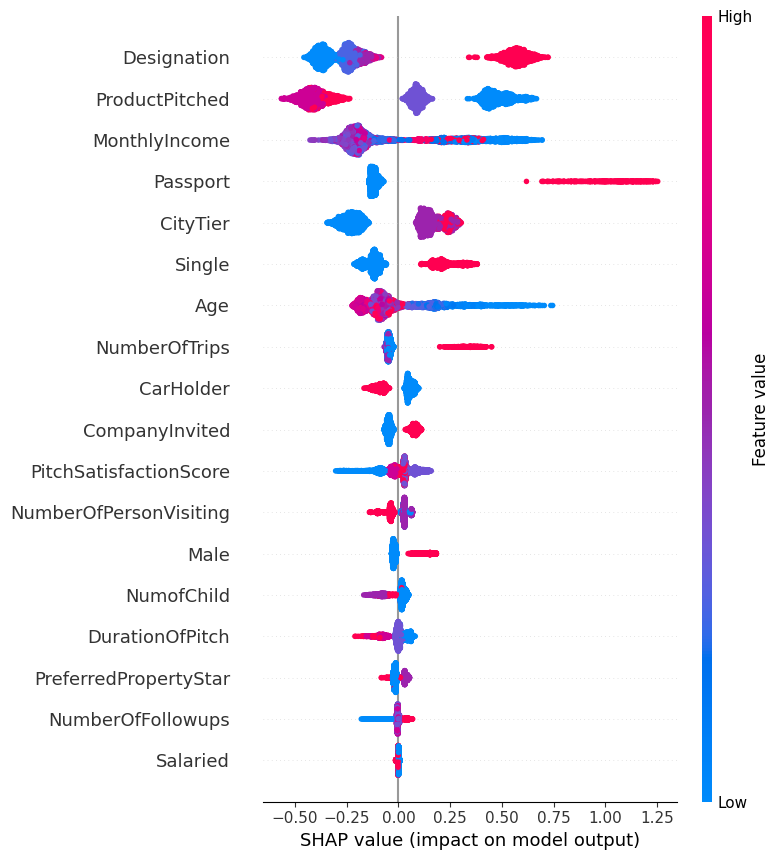

In [415]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()
explainer = shap.TreeExplainer(model=models[0])
# 横軸：SHAP値 (0からの貢献度、右=プラスの影響)
# 縦軸：特徴量 (上にあるほど重要)
# 色：その特徴の値 (赤=大きい値、青=小さい値)
# ① SHAPのexplainerを作成
explainer = shap.TreeExplainer(models[0])
# ② SHAP値を計算（X_trainは学習に使った特徴量データ）
shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))
# ③ summary plotで全体の重要度と分布を見る
shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

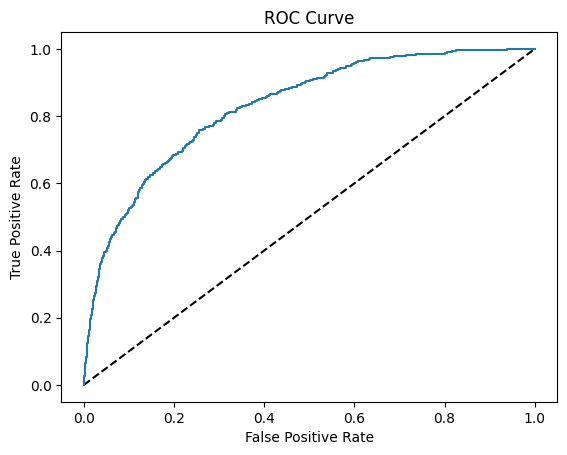

In [416]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [417]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [418]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [419]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)